In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

Encoder

In [2]:
encoded_input = keras.Input(shape=(32, 32, 3), name="image_input")
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(encoded_input)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(128, activation='relu')(x)

model_encoder = keras.Model(encoded_input, encoder_output, name='model_encoder')

Metal device set to: Apple M1 Pro


2022-08-16 15:59:46.160826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-16 15:59:46.160976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Decoder

In [3]:
decoder_input = keras.layers.Dense(256, activation='relu')(encoder_output)

x = keras.layers.Reshape((4, 4, 16))(decoder_input)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)

decoded = layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(x)

CNN AE

In [4]:
autoencoder = keras.Model(encoded_input, decoded, name='model_cnn_autoencoder')

In [5]:
autoencoder.summary()

Model: "model_cnn_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)

In [7]:
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
autoencoder.compile(optimizer=optimizer_adam, loss='mse')

In [8]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
epochs = 15

for epoch in range(epochs):
    history = autoencoder.fit(x_train, x_train, epochs=1, batch_size=128, validation_split=0.1, callbacks=[TensorBoard(log_dir='../data/autoencoder')])
    autoencoder.save(f"../models/ModelCNNAutoEncoder-{epoch+1}.model")

In [16]:
# terminal command: tensorboard --logdir=./data/autoencoder

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='../data/autoencoder')])

2022-08-16 16:04:51.165978: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 16:04:51.165994: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 16:04:51.166499: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
   9/1563 [..............................] - ETA: 30s - loss: 0.0108

2022-08-16 16:04:53.092858: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 16:04:53.092878: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 16:04:53.120389: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-16 16:04:53.120812: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 16:04:53.121320: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../data/autoencoder/train/plugins/profile/2022_08_16_16_04_53

2022-08-16 16:04:53.121846: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../data/autoencoder/train/plugins/profile/2022_08_16_16_04_53/MacBook-Pro-van-Koray.local.trace.json.gz
2022-08-16 16:04:53.122335: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../data/autoencoder/train/plugin

1563/1563 [==============================] - 28s 18ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 2/100
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 3/100
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 5/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 6/100
1563/1563 [==============================] - 26s 17ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 8/100
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 9/100
1563/1563 [==============================] - 27s 17ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 10/100
1563/1563 [==============================] - 27s 17ms/

In [28]:
# terminal command: tensorboard --logdir=./data/autoencoder

autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='../data/autoencoder')])

2022-08-16 17:19:55.206325: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 17:19:55.206353: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 17:19:55.206546: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/150
  7/391 [..............................] - ETA: 12s - loss: 0.0065

2022-08-16 17:19:56.787733: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-16 17:19:56.787744: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-16 17:19:56.818477: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-16 17:19:56.818910: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-16 17:19:56.819405: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../data/autoencoder/train/plugins/profile/2022_08_16_17_19_56

2022-08-16 17:19:56.820113: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ../data/autoencoder/train/plugins/profile/2022_08_16_17_19_56/MacBook-Pro-van-Koray.local.trace.json.gz
2022-08-16 17:19:56.820562: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ../data/autoencoder/train/plugin

391/391 [==============================] - 13s 34ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 2/150
391/391 [==============================] - 13s 33ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 3/150
391/391 [==============================] - 12s 30ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 4/150
391/391 [==============================] - 12s 30ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 5/150
391/391 [==============================] - 12s 30ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 6/150
391/391 [==============================] - 12s 31ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 7/150
391/391 [==============================] - 12s 31ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 8/150
391/391 [==============================] - 12s 31ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 9/150
391/391 [==============================] - 12s 31ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 10/150
391/391 [==============================] - 12s 31ms/step - loss: 0.0066 

In [30]:
autoencoder.save(f"../models/ModelCNNAutoEncoder-{300}.model")

INFO:tensorflow:Assets written to: ../models/ModelCNNAutoEncoder-300.model/assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


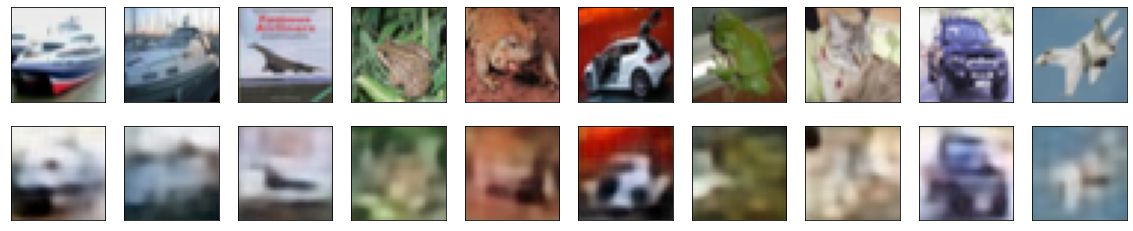

In [29]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

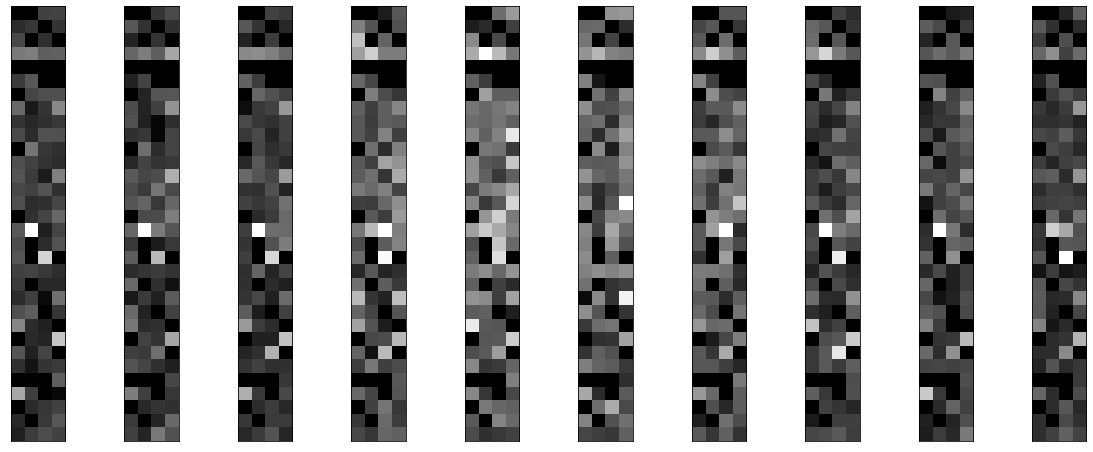

In [31]:
encoded_imgs = model_encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  # shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  # long_dim = max(shape)
  # scale = max_dim / long_dim
  #
  # new_shape = tf.cast(shape * scale, tf.int32)
  #
  # img = tf.image.resize(img, new_shape)
  # img = img[tf.newaxis, :]
  return img

path = '../data/test.png'
x = load_img(path)

plt.imshow(x)

In [33]:
test_decoded_imgs = autoencoder.predict(np.array([x]))

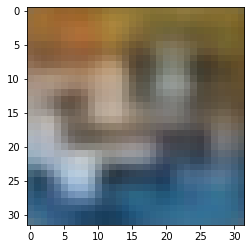

In [21]:
plt.imshow(decoded_imgs[0].reshape(32, 32, 3))